# Marketing Mailing Predictive Analytics

This project aims to build a model to predict which customers would respond to the marketing mailing. 

The company's goal is to get 1.5 million revenue increase by sending out marketing mailings to target customers with the lowest cost. After simple calculation, our final goal is to identify 1,667 positive-reponse customers by building a classification model.

- Firstly we pre-processed the training dataset to build the model. We did EDA to support variable selection, and combined all the independent variables into a column called "features" for further model building usage. Similarly, we prepared the dataset we want to predict -- future dataset. 

- Then we selected the best threshold according to the true positives we want to get.

- Finally we utilized the final model with the best threshold to classify the future dataset. The model flagged 5,022 customers, which potentially leads to 1,667 true reponses and 1.5 million revenue increase.

## Reading Data

In [86]:
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import numpy as np

findspark.init('/usr/local/Cellar/apache-spark/2.4.5/libexec')
spark = SparkSession.builder.appName('final').getOrCreate()

In [87]:
# Read data
customers = spark.read.csv("Customers.csv", inferSchema=True, header=True) 
demog = spark.read.csv("Demog.csv", inferSchema=True, header=True)
mailings_1_2 = spark.read.csv("Mailings1_2.csv", inferSchema=True, header=True) 
mailings_3 = spark.read.csv("mailings3.csv", inferSchema=True, header=True)
sales = spark.read.csv("Sales.csv", inferSchema=True, header=True)

# Create tempview for each dataset
customers.createOrReplaceTempView("customers")
demog.createOrReplaceTempView("demog")
mailings_1_2.createOrReplaceTempView("mailings_1_2")
mailings_3.createOrReplaceTempView("mailings_3")
sales.createOrReplaceTempView("sales")

## Data Preparation

In [153]:
# Join the tables
customers_sales_aggregate = spark.sql(
"""
SELECT
c.ID,
SUM(AMOUNT) sum_amount,
COUNT(AMOUNT) cnt_amount
FROM customers c
LEFT JOIN sales s ON c.ID = s.REFID
where (date(EVENT_DATE) < "2007-03-01" and s.REFID >= 30000) or date(EVENT_DATE) < "2007-02-01"
GROUP BY c.ID
""")
customers_sales_aggregate.createOrReplaceTempView("customers_sales_aggregate")

customers_info_all = spark.sql(
"""
SELECT
*
FROM customers c
INNER JOIN mailings_1_2 m_1 on c.ID = m_1.REFID
LEFT JOIN demog d ON c.GEOID = d.GEOID
LEFT JOIN customers_sales_aggregate csa ON c.ID = csa.ID
""")
customers_info_all.createOrReplaceTempView("customers_info_all")

customers_info_all_drop = customers_info_all.drop("ID","REFID","KxIndex","GEOID","REF_DATE")
customers_info_all_drop.createOrReplaceTempView("customers_info_all_drop")
# Change response to label(int)
response_transfer = spark.sql("""
select *,
case when RESPONSE = TRUE then 1   
     else 0 end as label
from customers_info_all_drop                        
""").drop("RESPONSE")

# Change label(int) to label(double)
response_transfer = response_transfer.withColumn("label", response_transfer["label"].cast(DoubleType()) )
response_transfer.createOrReplaceTempView("response_transfer")
response_transfer.show(5)

+------+--------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------------+----------+-----+
|   SEX|MARITAL_STATUS|EDUCATIONNUM|       OCCUPATION|DATA1|DATA2|DATA3|NOM1|NOM2|NOM3|age|INHABITANTS_K|INCOME_K|A_VAR1|A_VAR2|A_VAR3|A_VAR4|A_VAR5|A_VAR6|A_VAR7|A_VAR8|A_VAR9|A_VAR10|A_VAR11|A_VAR12|A_VAR13|A_VAR14|A_VAR15|A_VAR16|A_VAR17|A_VAR18|        sum_amount|cnt_amount|label|
+------+--------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------------+----------+-----+
|  Male|      Divorced|           6|Machine-op-inspct|9.113| 3.77|7.521|   m|   q|   o| 27|       44.525| 2354.73| 7.913|  8.53| 9.821| 4.522|

## EDA for Categorical Variables

Text(0.5, 1.0, 'Count of each categories for Sex')

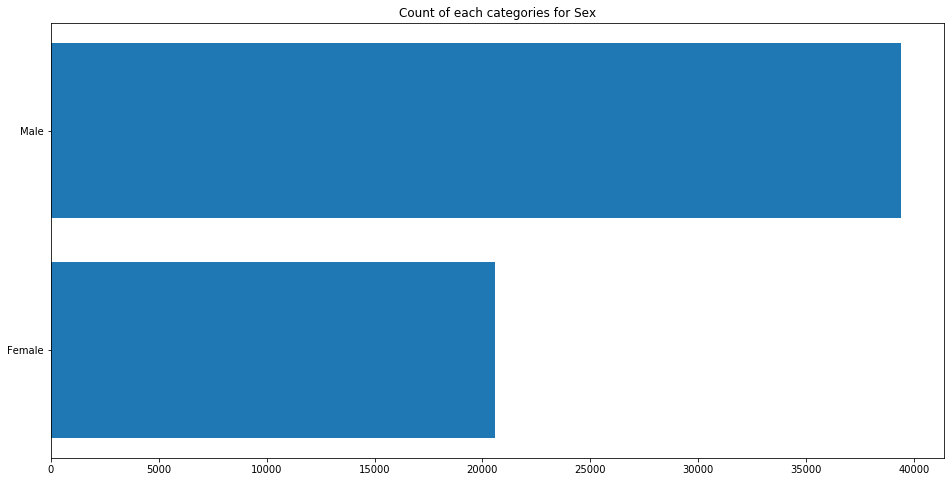

In [155]:
# bar chart for Sex
sex_desc = spark.sql(   
"""
select
sex,
COUNT(*) as num
from response_transfer
GROUP BY sex
""")
sex_desc_df = sex_desc.toPandas()
sex_list = list(sex_desc_df['sex'])
sex_num_list = list(sex_desc_df['num'])

plt.figure(figsize=(16,8))
plt.barh(sex_list,sex_num_list)
plt.title("Count of each categories for Sex")

Text(0.5, 1.0, 'Count of each categories for Marital Status')

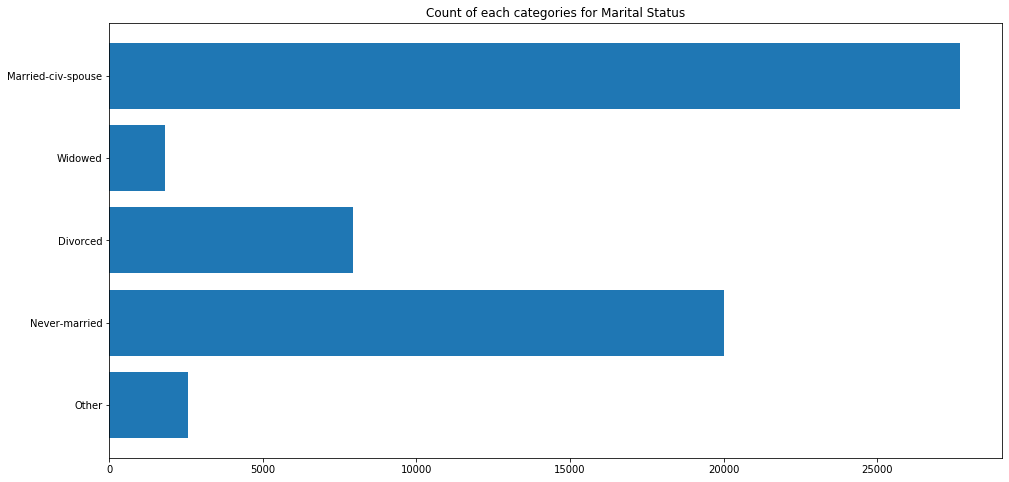

In [156]:
# bar chart for Marital Status
marital_desc = spark.sql(   
"""
select
marital_status,
COUNT(*) as num
from response_transfer
GROUP BY marital_status
""")
marital_desc_df = marital_desc.toPandas()
marital_list = list(marital_desc_df['marital_status'])
marital_num_list = list(marital_desc_df['num'])

plt.figure(figsize=(16,8))
plt.barh(marital_list,marital_num_list)
plt.title("Count of each categories for Marital Status")

Text(0.5, 1.0, 'Count of each categories for Occupation')

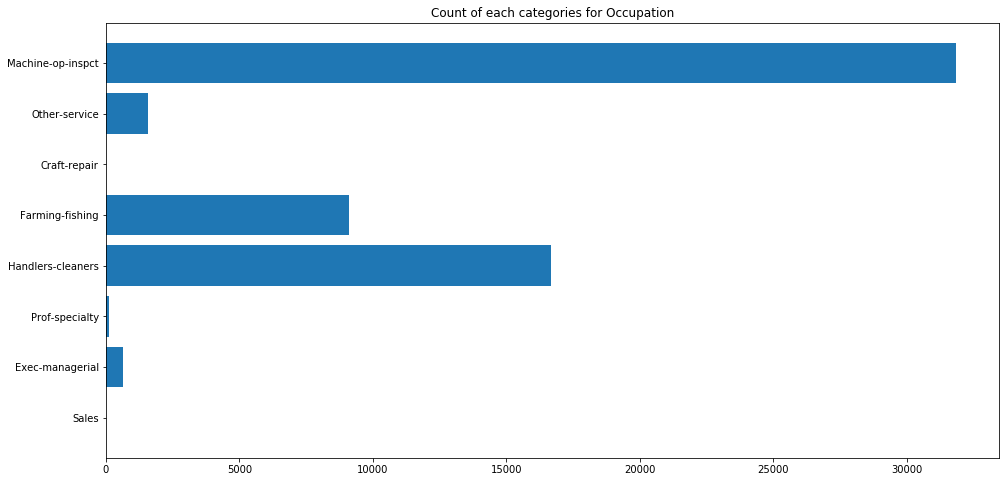

In [157]:
# bar chart for Occupation
occupation_desc = spark.sql(   
"""
select
OCCUPATION,
COUNT(*) as num
from response_transfer
GROUP BY OCCUPATION
""")
occupation_desc_df = occupation_desc.toPandas()
occupation_list = list(occupation_desc_df['OCCUPATION'])
occupation_num_list = list(occupation_desc_df['num'])

plt.figure(figsize=(16,8))
plt.barh(occupation_list,occupation_num_list)
plt.title("Count of each categories for Occupation")

Text(0.5, 1.0, 'Count of each categories for Nom 1')

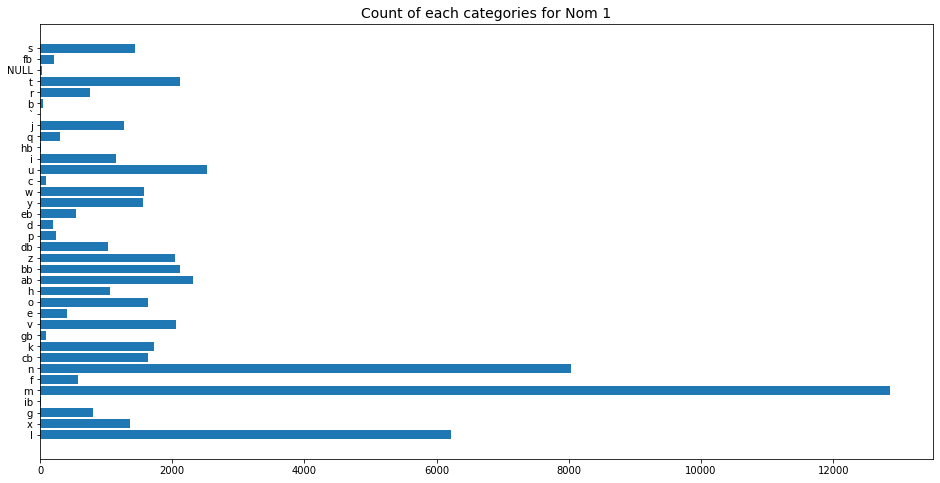

In [158]:
# bar chart for Nom 1
nom_1_desc = spark.sql(
"""
select
NOM1,
COUNT(*) as num
from response_transfer
GROUP BY NOM1
""")
nom_1_desc_df = nom_1_desc.toPandas()
nom_1_list = list(nom_1_desc_df['NOM1'])
nom_1_num_list = list(nom_1_desc_df['num'])

plt.figure(figsize=(16,8))
plt.barh(nom_1_list,nom_1_num_list)
plt.title("Count of each categories for Nom 1", fontsize =14)

Text(0.5, 1.0, 'Count of each categories for Nom 2')

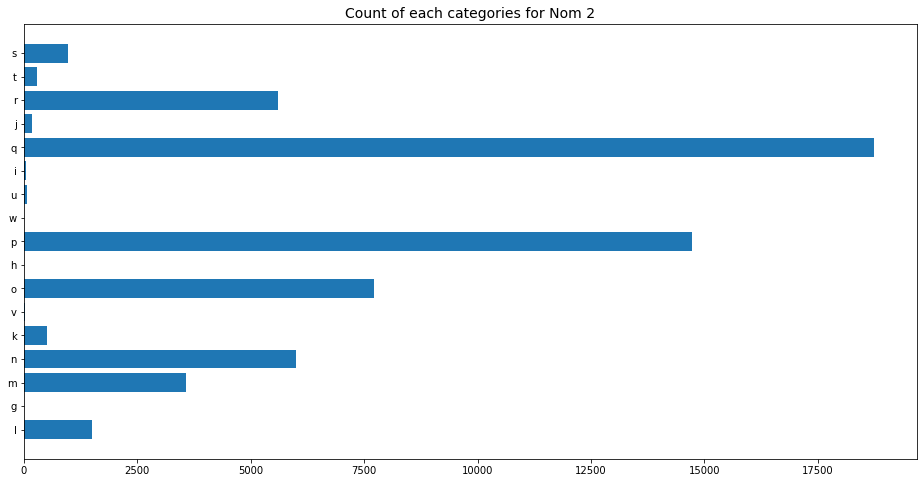

In [159]:
# bar chart for Nom 2
nom_2_desc = spark.sql(
"""
select
NOM2,
COUNT(*) as num
from response_transfer
GROUP BY NOM2
""")
nom_2_desc_df = nom_2_desc.toPandas()
nom_2_list = list(nom_2_desc_df['NOM2'])
nom_2_num_list = list(nom_2_desc_df['num'])

plt.figure(figsize=(16,8))
plt.barh(nom_2_list,nom_2_num_list)
plt.title("Count of each categories for Nom 2", fontsize =14)

Text(0.5, 1.0, 'Count of each categories for Nom 3')

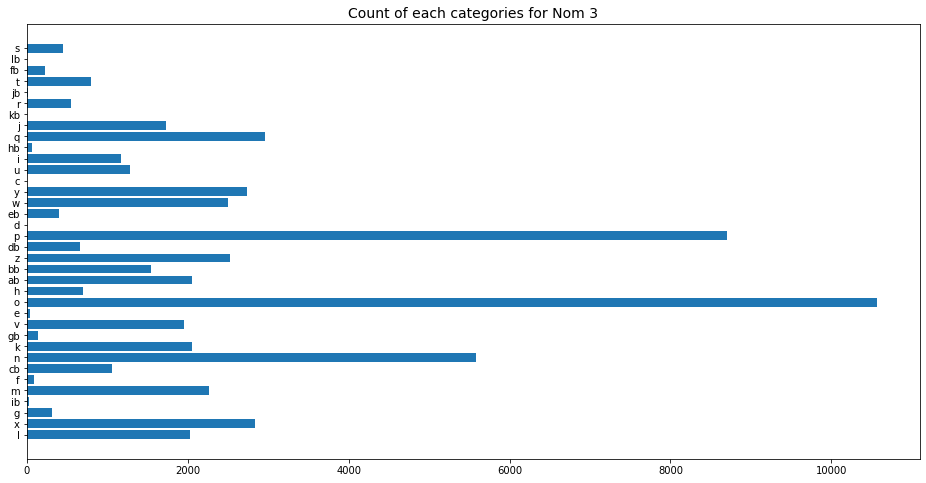

In [160]:
# bar chart for Nom 3
nom_3_desc = spark.sql(
"""
select
NOM3,
COUNT(*) as num
from response_transfer
GROUP BY NOM3
""")
nom_3_desc_df = nom_3_desc.toPandas()
nom_3_list = list(nom_3_desc_df['NOM3'])
nom_3_num_list = list(nom_3_desc_df['num'])

plt.figure(figsize=(16,8))
plt.barh(nom_3_list,nom_3_num_list)
plt.title("Count of each categories for Nom 3", fontsize =14)

## Training Data Preparation

In [161]:
# Balance the data because there are too few positive responses
balancingRatio = response_transfer.where("label=1").count() / response_transfer.count()

def calculateWeights(d):
      if d == 0.0:
        return 1 * balancingRatio
      else:
        return 1 * (1.0 - balancingRatio)
calculateWeights_udf = udf(calculateWeights)   

df_weight = response_transfer.withColumn("weight", calculateWeights_udf("label").cast(DoubleType()))
cols = df_weight.columns
df_weight.show(5)

+------+--------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------------+----------+-----+------+
|   SEX|MARITAL_STATUS|EDUCATIONNUM|       OCCUPATION|DATA1|DATA2|DATA3|NOM1|NOM2|NOM3|age|INHABITANTS_K|INCOME_K|A_VAR1|A_VAR2|A_VAR3|A_VAR4|A_VAR5|A_VAR6|A_VAR7|A_VAR8|A_VAR9|A_VAR10|A_VAR11|A_VAR12|A_VAR13|A_VAR14|A_VAR15|A_VAR16|A_VAR17|A_VAR18|        sum_amount|cnt_amount|label|weight|
+------+--------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------------+----------+-----+------+
|  Male|      Divorced|           6|Machine-op-inspct|9.113| 3.77|7.521|   m|   q|   o| 27|       44.525| 2354.73| 7.913|

In [162]:
# Put all the independent variables into a column called "features"
categoricalColumns = ['SEX', 'MARITAL_STATUS']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"classVec"])
    stages += [stringIndexer, encoder]

numericCols = ['EDUCATIONNUM','DATA1','DATA2','DATA3','age','INHABITANTS_K','INCOME_K','A_VAR1','A_VAR2','A_VAR3','A_VAR4',\
               'A_VAR5','A_VAR6','A_VAR7','A_VAR8','A_VAR9','A_VAR10','A_VAR11','A_VAR12','A_VAR13',\
               'A_VAR14','A_VAR15','A_VAR16','A_VAR17','A_VAR18','sum_amount','cnt_amount']

# assemblerInputs = numericCols
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [163]:
# Use pipeline to combine variables
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_weight)
df = pipelineModel.transform(df_weight)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.show(5)

+--------------------+------+--------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------------+----------+-----+------+
|            features|   SEX|MARITAL_STATUS|EDUCATIONNUM|       OCCUPATION|DATA1|DATA2|DATA3|NOM1|NOM2|NOM3|age|INHABITANTS_K|INCOME_K|A_VAR1|A_VAR2|A_VAR3|A_VAR4|A_VAR5|A_VAR6|A_VAR7|A_VAR8|A_VAR9|A_VAR10|A_VAR11|A_VAR12|A_VAR13|A_VAR14|A_VAR15|A_VAR16|A_VAR17|A_VAR18|        sum_amount|cnt_amount|label|weight|
+--------------------+------+--------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------------+----------+-----+------+
|[1.0,0.0,0.0,1.0,...|  Male|      Divorced|           6|M

## Future Dataset Preparation

In [164]:
# Join the tables for mailings_3 which is the future dataset
customers_sales_aggregate = spark.sql(
"""
SELECT
c.ID,
SUM(AMOUNT) sum_amount,
COUNT(AMOUNT) cnt_amount
FROM customers c
LEFT JOIN sales s ON c.ID = s.REFID
where date(EVENT_DATE) > "2007-04-01" and date(EVENT_DATE) < "2007-07-01"
GROUP BY c.ID
""")
customers_sales_aggregate.createOrReplaceTempView("customers_sales_aggregate")

customers_info_all = spark.sql(
"""
SELECT
*
FROM customers c
INNER JOIN mailings_3 m_1 on c.ID = m_1.REFID
LEFT JOIN demog d ON c.GEOID = d.GEOID
LEFT JOIN customers_sales_aggregate csa ON c.ID = csa.ID
""")
customers_info_all.createOrReplaceTempView("customers_info_all")
customers_info_all_drop = customers_info_all.drop("ID","REFID","KxIndex","GEOID","REF_DATE")

# Change Response to label(int)
customers_info_all_drop.createOrReplaceTempView("customers_info_all_drop")
response_transfer_future = spark.sql("""
select *,
case when RESPONSE = TRUE then 1
     else 0 end as label
from customers_info_all_drop                        
""").drop("RESPONSE")

# Change label(int) to label(double)
response_transfer_future = response_transfer_future.withColumn("label", response_transfer_future["label"].cast(DoubleType()) )
response_transfer_future.createOrReplaceTempView("response_transfer_future")
cols_future = response_transfer_future.columns
response_transfer_future.show(5)

+----+------------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+----------+-----+
| SEX|    MARITAL_STATUS|EDUCATIONNUM|       OCCUPATION|DATA1|DATA2|DATA3|NOM1|NOM2|NOM3|age|INHABITANTS_K|INCOME_K|A_VAR1|A_VAR2|A_VAR3|A_VAR4|A_VAR5|A_VAR6|A_VAR7|A_VAR8|A_VAR9|A_VAR10|A_VAR11|A_VAR12|A_VAR13|A_VAR14|A_VAR15|A_VAR16|A_VAR17|A_VAR18|       sum_amount|cnt_amount|label|
+----+------------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+----------+-----+
|Male|     Never-married|           4|Machine-op-inspct|4.986|5.164|5.743|   z|   q|   z| 22|       49.216| 2606.09| 6.242| 5.586| 8.828| 3

In [165]:
# Put all the independent variables into a column called "features"
categoricalColumns = ['SEX', 'MARITAL_STATUS']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"classVec"])
    stages += [stringIndexer, encoder]

numericCols = ['EDUCATIONNUM','DATA1','DATA2','DATA3','age','INHABITANTS_K','INCOME_K','A_VAR1',\
               'A_VAR2','A_VAR3','A_VAR4','A_VAR5','A_VAR6','A_VAR7','A_VAR8','A_VAR9','A_VAR10',\
               'A_VAR11','A_VAR12','A_VAR13','A_VAR14','A_VAR15','A_VAR16','A_VAR17','A_VAR18',\
               'sum_amount','cnt_amount']

# assemblerInputs = numericCols
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [166]:
# Use pipeline to combine variables
pipeline_future = Pipeline(stages = stages)
pipelineModel_future = pipeline_future.fit(response_transfer_future)
df_future = pipelineModel_future.transform(response_transfer_future)
selectedCols_future = ['features'] + cols_future
df_future = df_future.select(selectedCols_future)
df_future.show(5)

+--------------------+----+------------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+----------+-----+
|            features| SEX|    MARITAL_STATUS|EDUCATIONNUM|       OCCUPATION|DATA1|DATA2|DATA3|NOM1|NOM2|NOM3|age|INHABITANTS_K|INCOME_K|A_VAR1|A_VAR2|A_VAR3|A_VAR4|A_VAR5|A_VAR6|A_VAR7|A_VAR8|A_VAR9|A_VAR10|A_VAR11|A_VAR12|A_VAR13|A_VAR14|A_VAR15|A_VAR16|A_VAR17|A_VAR18|       sum_amount|cnt_amount|label|
+--------------------+----+------------------+------------+-----------------+-----+-----+-----+----+----+----+---+-------------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+----------+-----+
|[1.0,0.0,1.0,0.0,...|Male|     Never-married|           4|Machine-op-inspct

## Find the Best Threshold

In [167]:
# Split the dataset
train, test = df.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Positive Count: " + str(train.where("label=1").count()))
print("Test Dataset Positive Count: " + str(test.where("label=1").count()))

Training Dataset Positive Count: 2106
Test Dataset Positive Count: 888


In [168]:
# Get the customer classification result from logistic regression function for a specific threshold
def logistic_function(threshold):
    lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter=10,weightCol="weight",threshold=threshold)
    lr_model=lr.fit(train)
    predict_train=lr_model.transform(train)
    predict_test = lr_model.transform(test)
    target = predict_test.where("prediction=1 and label=1").count() 
    print(threshold, target)

In [169]:
# For future dataset, we want to find out 1,667 among 300,000 customers, which is 0.56%
# For test dataset, we want to find out 0.56% of 18,000 customers, which is 100
for threshold in np.arange(0.70,0.75,0.01):
    logistic_function(threshold)

0.7 152
0.71 134
0.72 111
0.73 96
0.74 85
0.75 76


We selectec 0.73 as the best threshold because 96 is just little smaller than 100.

## Build the Final Logistic Regression Model with the Best Threshold

In [170]:
# Build logistic regression model with 0.73 as the threshold
lr = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10,weightCol="weight", threshold=0.73)
lr_model=lr.fit(train)
predict_train=lr_model.transform(train)
predict_test = lr_model.transform(test)

# Check the number of positives we got
predict_test.where("prediction=1").count()

291

In [180]:
# Check the coefficients
print(lr_model.coefficients)

[0.08537150214623974,0.10782995412079281,0.12066416013433731,0.17862967133131252,0.3520107191008278,-0.12125205897588563,-0.013177430288232851,-0.01844444434371642,-0.008437194311490257,2.8393428289485458e-05,-0.003549498967169395,5.678491321949731e-05,-0.05683262742579435,0.07011669153488945,0.01882614386715209,-0.0540171987104696,0.014534086751070137,-0.037521350202947036,0.02018679744862735,0.004921450374144094,-0.029484892940786624,0.06975489534974383,0.08370438451499601,0.07219954921391872,0.0024122033709455173,0.03812267209318475,0.07395184615036704,0.0248668969845224,-0.037407252737106135,0.08577833880566367,-0.006118858939273973,-0.10256323906298366]


In [182]:
print(lr_model.summary)

## Model Evaluation

In [171]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

# AUC
print('Test Area Under ROC', evaluator.evaluate(predict_test))

Test Area Under ROC 0.6848852885611616


In [172]:
# Precision
predict_test.where("prediction=1 and label=1").count() / predict_test.where("prediction=1").count()

0.32989690721649484

In [173]:
# Recall
predict_test.where("prediction=1 and label=1").count() / predict_test.where("label=1").count()

0.10810810810810811

## Future Dataset Prediction

In [174]:
# Check the number of all the positives we predicted
predict_future = lr_model.transform(df_future)
predict_future.where("prediction=1").count()

5022

In [175]:
# AUC
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predict_future))

Test Area Under ROC 0.6643005386194675


In [176]:
# Precision
predict_future.where("prediction=1 and label=1").count() / predict_future.where("prediction=1").count()

0.3343289526085225

In [177]:
# Recall
predict_future.where("prediction=1 and label=1").count() / predict_future.where("label=1").count()

0.1133923144458702

## Summary
Leveraging the model we developed, the company only needs to send marketing mailings to 5022 customers. 

According to the precision, 5,022*33.4% = 1679 customers will respond, which leads to a potential revenue increase of 1.5 million in the following 3 months.